# Ingeniería de Atributos con Random Forest

Vamos a realizar la ingeniería de atributos sobre los datos de la competencia de [kaggle](www.kaggle.com) para la predicción del precio de subasta de equipo pesado denominda [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers). Este notebook esta basado en el curso de [Aprendizaje Automático de fast.ai](fast.ai/ml).

<img src='../figuras/Bulldozer.png'/>

## Importar las librerías a utilizar

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

## Leer los datos

In [2]:
data_bruta = pd.read_csv('../datos/bulldozer_train.csv', parse_dates=['saledate'])
data_bruta.head(10).T

/Users/wladimir/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275
SalePrice,66000,57000,10000,38500,11000,26500,21000,27000,21500,65000
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883
datasource,121,121,121,121,121,121,121,121,121,121
auctioneerID,3,3,3,3,3,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007,2004,1993,2001,2008,1000
MachineHoursCurrentMeter,68,4640,2838,3486,722,508,11540,4883,302,20700
UsageBand,Low,Low,High,High,Medium,Low,High,High,Low,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00,2008-12-18 00:00:00,2004-08-26 00:00:00,2005-11-17 00:00:00,2009-08-27 00:00:00,2007-08-09 00:00:00


### Observando los datos

In [3]:
data_bruta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

Dando una mirada rápida, podemos ver que hay:

- **Atributos numéricos**: medición o recuento (SalePrice, BladeWidth)
- **Atributos categóricos**: ordinales y nominales (TrackType, EnclosureType, ProductSize, UsageBand)
- **Atributos de fecha/tiempo**: (SaleDate)
- **Identificadores**: (MachineId, ModelId)

In [4]:
data_bruta.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podemos observar que el atributo `YearMade` tiene como valor mínimo el año 1000, lo que indicaría que hay datos errados en ese artributo. Vamos a gráficar el atributo como un histograma para observar los valores del atributo:

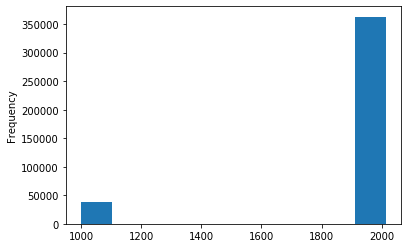

In [5]:
data_bruta.YearMade.plot(kind='hist');

Del histograma podemos observar que hay más de 4000 observaciones con valores cercanos al año 1000. Procederemos a eliminar todos aquellas observaciones en donde el aributo `YearMade` es menor a 1930,

In [8]:
data_bruta = data_bruta[data_bruta.YearMade > 1930]

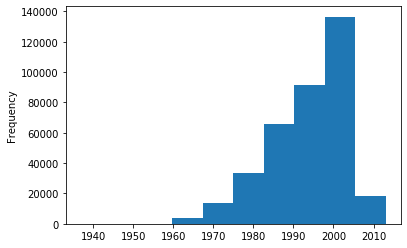

In [9]:
data_bruta.YearMade.plot(kind='hist');

## Preprocesamiento

Aplicaremos algunas de las técnicas de preprocesamiento tales como:

- Transformación **Logarítmica**
- Manejo de atributos categoricos
- Manejo de valores faltantes
- Extraer datos de la Fecha/Tiempo


### Transformación Logarítmica

Si ve las [métricas de evaluación](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), quieren la raiz cuadrada de la media del  error logarítmico cuadratico.

> RMSE: desviación estándar de los errores de predicción de nuestro modelo

In [10]:
def rmse(actual, prediccion): 
    return np.sqrt(np.mean((actual - prediccion)**2))

Esto es común para un atributo como el precio. Están más interesados si se equivoco un $10\%$ que si se equivoco en $\$10$. Si es un artículo de $\$10,000$ y usted está equivocado por $\$1000$ o si es un artículo de $\$100$ y está fuera por $\$10$, se considerarán problemas equivalentes.

Aplicar el logaritmo acerca los datos a una distribución normal. Entonces, si los errores de predicción se distribuyen normalmente, alrededor del $95\%$ de los errores de predicción estarían en $± 2 * RMSE$. También disminuye el efecto de cualquier valor atípico en los datos. RMSE es la métrica que optimizaremos matemáticamente e intentaremos reducirla a 0.

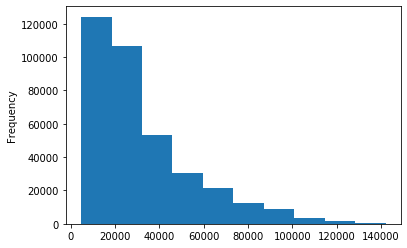

In [11]:
data_bruta.SalePrice.plot(kind='hist');

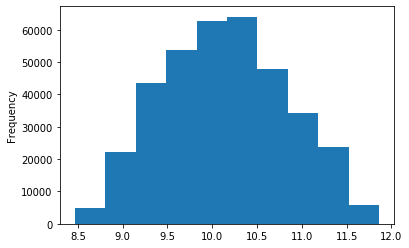

In [12]:
data_bruta.SalePrice = np.log(data_bruta.SalePrice)
data_bruta.SalePrice.plot(kind='hist');

### Convertir atributos tipo object (cadenas de caracteres) a categorías

Vamos a convertir las columnas de cadenas de caracteres del dataframe a valores de categorías.

#### Función para convertir atributos a tipo categoría

In [13]:
def cambiar_a_categorias(dataframe):
    for n, c in dataframe.items():
        if is_string_dtype(c):
            dataframe[n] = c.astype('category').cat.as_ordered()

In [14]:
%time cambiar_a_categorias(data_bruta)

CPU times: user 3.01 s, sys: 653 ms, total: 3.67 s
Wall time: 3.67 s


In [15]:
data_bruta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362796 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   362796 non-null  int64         
 1   SalePrice                 362796 non-null  float64       
 2   MachineID                 362796 non-null  int64         
 3   ModelID                   362796 non-null  int64         
 4   datasource                362796 non-null  int64         
 5   auctioneerID              345222 non-null  float64       
 6   YearMade                  362796 non-null  int64         
 7   MachineHoursCurrentMeter  126266 non-null  float64       
 8   UsageBand                 64577 non-null   category      
 9   saledate                  362796 non-null  datetime64[ns]
 10  fiModelDesc               362796 non-null  category      
 11  fiBaseModel               362796 non-null  category      
 12  fi

In [16]:
data_bruta.UsageBand.cat.codes

0         1
1         1
2         0
3         0
4         2
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 362796, dtype: int8

### Rellenar de valores faltantes

Es difícil encontrar un conjunto de datos de la vida real sin que se generen valores faltantes debido a razones diversas. Puede no tomarlos en cuenta simplemente eliminando filas completas que contienen algunas características faltantes.

En lugar de eliminar filas enteras y reducir el tamaño del conjunto de datos, podemos llenarlas usando su *media*, *mediana* o *modo*. También puede usar algoritmos como k-NN y MICE (Multivariate Imputation by Chained Equations) para hacerlo. No hay mejor manera de completar los valores faltantes. Una técnica que funciona en un conjunto de datos con ciertos valores faltantes puede no funcionar en otro.

En nuestro ejemplo llenaremos los valores faltantes con la *mediana*.

#### Función para rellenar valores faltantes con la mediana

In [17]:
def rellenar_faltantes(dataframe, columna, nombre, dict_na):
    if is_numeric_dtype(columna):
        if pd.isnull(columna).sum() or (nombre in dict_na):
            dataframe[nombre + '_na'] = pd.isnull(columna)
            relleno = dict_na[nombre] if nombre in dict_na else columna.median()
            dataframe[nombre] = columna.fillna(relleno)
            dict_na[nombre] = relleno
    return dict_na

Aplicar función:

In [18]:
dict_na = {}
for nombre, columna in data_bruta.items():
    rellenar_faltantes(data_bruta, columna, nombre, dict_na)

Campos agregados:

In [19]:
dict_na

{'auctioneerID': 1.0, 'MachineHoursCurrentMeter': 200.0}

In [20]:
data_bruta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362796 entries, 0 to 401124
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SalesID                      362796 non-null  int64         
 1   SalePrice                    362796 non-null  float64       
 2   MachineID                    362796 non-null  int64         
 3   ModelID                      362796 non-null  int64         
 4   datasource                   362796 non-null  int64         
 5   auctioneerID                 362796 non-null  float64       
 6   YearMade                     362796 non-null  int64         
 7   MachineHoursCurrentMeter     362796 non-null  float64       
 8   UsageBand                    64577 non-null   category      
 9   saledate                     362796 non-null  datetime64[ns]
 10  fiModelDesc                  362796 non-null  category      
 11  fiBaseModel               

Aregaremos  1 a los códigos categóricos para que comiencen desde 0 en lugar de -1 (valor por defecto en pandas). Esto cambiara el tipo de dato de los atributos tipo categoría a enteros

In [21]:
def cambiar_de_categorias_a_int(dataframe):
    for nombre, columna in dataframe.items():
        if not is_numeric_dtype(columna) and nombre != 'saledate':
            dataframe[nombre] = columna.cat.codes + 1

In [22]:
cambiar_de_categorias_a_int(data_bruta)

In [23]:
data_bruta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362796 entries, 0 to 401124
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SalesID                      362796 non-null  int64         
 1   SalePrice                    362796 non-null  float64       
 2   MachineID                    362796 non-null  int64         
 3   ModelID                      362796 non-null  int64         
 4   datasource                   362796 non-null  int64         
 5   auctioneerID                 362796 non-null  float64       
 6   YearMade                     362796 non-null  int64         
 7   MachineHoursCurrentMeter     362796 non-null  float64       
 8   UsageBand                    362796 non-null  int8          
 9   saledate                     362796 non-null  datetime64[ns]
 10  fiModelDesc                  362796 non-null  int16         
 11  fiBaseModel               

In [24]:
data_bruta.UsageBand

0         2
1         2
2         1
3         1
4         3
         ..
401120    0
401121    0
401122    0
401123    0
401124    0
Name: UsageBand, Length: 362796, dtype: int8

## Extrayendo datos de `DateTime`

Si algunas de sus características son variables `DateTime`, podemos descomponerlas en algunos atributos útiles como: si fue un fin de semana, de qué año fue, etc. Dicha ingeniería a menudo se descuida, pero es muy útil para extraer la información temporal de los datos.

### Función para agregar atributos de `DateTime` 

In [25]:
def agregar_partes_fecha(dataframe, nombre_campo, eliminar=True, tiempo=False):
    campo = dataframe[nombre_campo]
    if not np.issubdtype(campo.dtype, np.datetime64):
        dataframe[nombre_campo] = campo = pd.to_datetime(campo, infer_datetime_format=True)
    prefijo = re.sub('[Dd]ate$', '', nombre_campo)
    atributos = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'DayofYear', 'Is_month_end', 'Is_month_start',
                'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if tiempo:
        atributos = atributos + ['Hour', 'Minute', 'Second']
    for atributo in atributos:
        dataframe[prefijo + atributo] = getattr(campo.dt, atributo.lower())
    dataframe[prefijo + 'Elapsed'] = campo.astype(np.int64)
    if eliminar:
        dataframe.drop(nombre_campo, axis=1, inplace=True)


In [26]:
agregar_partes_fecha(data_bruta, 'saledate')

In [27]:
data_bruta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362796 entries, 0 to 401124
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SalesID                      362796 non-null  int64  
 1   SalePrice                    362796 non-null  float64
 2   MachineID                    362796 non-null  int64  
 3   ModelID                      362796 non-null  int64  
 4   datasource                   362796 non-null  int64  
 5   auctioneerID                 362796 non-null  float64
 6   YearMade                     362796 non-null  int64  
 7   MachineHoursCurrentMeter     362796 non-null  float64
 8   UsageBand                    362796 non-null  int8   
 9   fiModelDesc                  362796 non-null  int16  
 10  fiBaseModel                  362796 non-null  int16  
 11  fiSecondaryDesc              362796 non-null  int16  
 12  fiModelSeries                362796 non-null  int8   
 13 

Ahora deberíamos tener una matriz limpia de enteros como su dataframe sin valores vacíos. Podemos guardar el dataframe y dividirlo en un conjunto de entrenamiento y validación.

## Crear dataframe de atributos y vector de objetivos

In [28]:
data_X = data_bruta.drop(['SalePrice'], axis=1)
y = data_bruta.SalePrice
print(data_X.shape, y.shape)

(362796, 66) (362796,)


In [29]:
data_bruta.to_feather('../datos/bulldozer_limpia')

ValueError: feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s)

#### Dividir la data en el conjunto de entrenamiento y el de validación

Vamos a crear un conjunto de validación de tamaño 12000 para que sea igual al conjunto de prueba. Queremos que nuestro conjunto de validación tengan las mismas propiedades del conjunto de prueba. Por lo tanto, mantenemos el tamaño del conjunto de validación igual que el conjunto de prueba.

In [30]:
def dividir_datos(dataframe, n_entrenamiento):
    return dataframe[:n_entrenamiento].copy(), dataframe[n_entrenamiento:].copy()

n_validacion = 12000  # Mismo tamaño al conjunto de prueba
n_entrenamiento = len(data_X) - n_validacion

X_entrenamiento, X_validacion = dividir_datos(data_X, n_entrenamiento)
y_entrenamiento, y_validacion = dividir_datos(y, n_entrenamiento)

len(X_entrenamiento), len(X_validacion), len(y_entrenamiento), len(y_validacion)

(350796, 12000, 350796, 12000)

## Interpretación Random Forest

Un conjunto de árboles de decisión entrenados en un conjunto de datos de arranque (muestreo aleatorio con reemplazo del mismo tamaño que el conjunto de datos original (389,125)) se denomina bosque aleatorio (Random Forest). Scikit-learn proporciona un RandomForestRegressor para predecir números continuos de punto flotante y un RandomForestClassifier para números discretos.

Vamos a entrenar a un RandomForestRegressor y echar un vistazo a sus predicciones.

In [31]:
modelo_1 = RandomForestRegressor(n_jobs=-1)
modelo_1.fit(X_entrenamiento, y_entrenamiento)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Imprimir medidas de exactitud:

In [32]:
def r2_score(actual, prediccion):
    return 1 - rmse(actual, prediccion)/ rmse(actual, np.mean(actual))

def imprimir_exactitud(modelo):
    print('RMSE Entrenamiento: ', rmse(modelo.predict(X_entrenamiento), y_entrenamiento) * 100)
    print('RMSE Validación: ', rmse(modelo.predict(X_validacion), y_validacion) * 100)
    print(' R2  Entrenamiento: ', modelo.score(X_entrenamiento, y_entrenamiento) * 100)
    print(' R2  Validación: ', modelo.score(X_validacion, y_validacion) * 100)
    if hasattr(modelo, 'oob_score_'): 
        print('   OOB    : ', modelo.oob_score_ * 100)

In [33]:
imprimir_exactitud(modelo_1)

RMSE Entrenamiento:  7.210407659109485
RMSE Validación:  22.70458305835965
 R2  Entrenamiento:  98.90286326500298
 R2  Validación:  90.94589666708664


Media y desviación estandar del modelo:

In [34]:
print('Media = ', np.mean(modelo_1.predict(X_validacion)))
print('Desviación Estándar = ', np.std(modelo_1.predict(X_validacion)))

Media =  10.067038329665623
Desviación Estándar =  0.7018077398212615


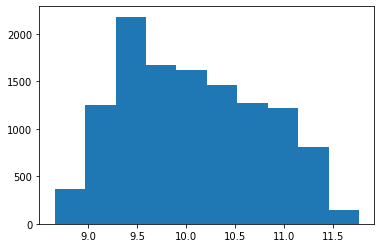

In [35]:
plt.hist(modelo_1.predict(X_validacion));

### Predicciones y Contribuciones de los Atributos

El resultado principal de un modelo son sus predicciones. Se encuentran alrededor de 10.01 y tienen una desviación estándar de 0.69. Si queremos saber cuánto contribuye cada característica a la predicción, podemos hacerlo utilizando un [Tree Interpreter](https://github.com/andosa/treeinterpreter).
Instalar usando pip:
```
pip install treeinterpreter
```

In [36]:
from treeinterpreter import treeinterpreter as ti
fila = X_validacion.values[None, 0]
fila

/Users/wladimir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


array([[4358764, 2274670, 532, 172, 1.0, 2000, 6443.0, 3, 3677, 1310, 0,
        52, 0, 3, 23, 25, 4, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, False,
        False, 2011, 9, 39, 29, 3, 272, False, False, False, False,
        False, False, 1317254400000000000]], dtype=object)

In [38]:
prediccion, sesgo, contribuciones = ti.predict(modelo_1, fila)

In [39]:
print('Sesgo = ', sesgo)
print('Predicción = ', prediccion)

Sesgo =  [10.14488255]
Predicción =  [[9.95094667]]


El sesgo (10.1448) mencionado anteriormente es la media de $y$ en el conjunto de entrenamiento. Eso es lo que agregaremos a las contribuciones [-0.02623, -0.02288, ... 0, -0.05563], para obtener la predicción (9.9509). Veamoslos de manera ordenada.

In [40]:
idxs = np.argsort(contribuciones[0])
[o for o in zip(X_validacion.columns[idxs], X_validacion.iloc[0][idxs], contribuciones[0][idxs])]
# Atributo,    Valor en la fila,    Contribución

[('fiModelDescriptor', 0, -0.22812412807651647),
 ('saleElapsed', 1317254400000000000, -0.19172023061495552),
 ('MachineID', 2274670, -0.1163149246916084),
 ('ModelID', 532, -0.11039972423380993),
 ('fiBaseModel', 1310, -0.07095485223459211),
 ('fiModelDesc', 3677, -0.06315495138398595),
 ('fiModelSeries', 52, -0.0243754131842447),
 ('fiSecondaryDesc', 0, -0.02355132543635097),
 ('auctioneerID', 1.0, -0.01577517060708619),
 ('Track_Type', 0, -0.008471624172288248),
 ('Coupler', 3, -0.004687192062524801),
 ('Thumb', 0, -0.002795012784861566),
 ('fiProductClassDesc', 23, -0.002602991030191184),
 ('datasource', 172, -0.002112809299724798),
 ('Grouser_Type', 0, -0.001077550323986518),
 ('auctioneerID_na', False, -0.0008787730749179446),
 ('saleDayofweek', 3, -0.0007924857328980473),
 ('ProductGroupDesc', 4, -0.000320170830694142),
 ('Stick_Length', 0, 0.0),
 ('Backhoe_Mounting', 0, 0.0),
 ('Blade_Type', 0, 0.0),
 ('Hydraulics_Flow', 0, 0.0),
 ('Grouser_Tracks', 0, 0.0),
 ('MachineHoursCurr

### Interpretación como Ȧrbol de Decisión

Observemos un solo árbol

In [42]:
arbol = DecisionTreeRegressor(max_depth=3)
arbol.fit(X_entrenamiento, y_entrenamiento)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

/Users/wladimir/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


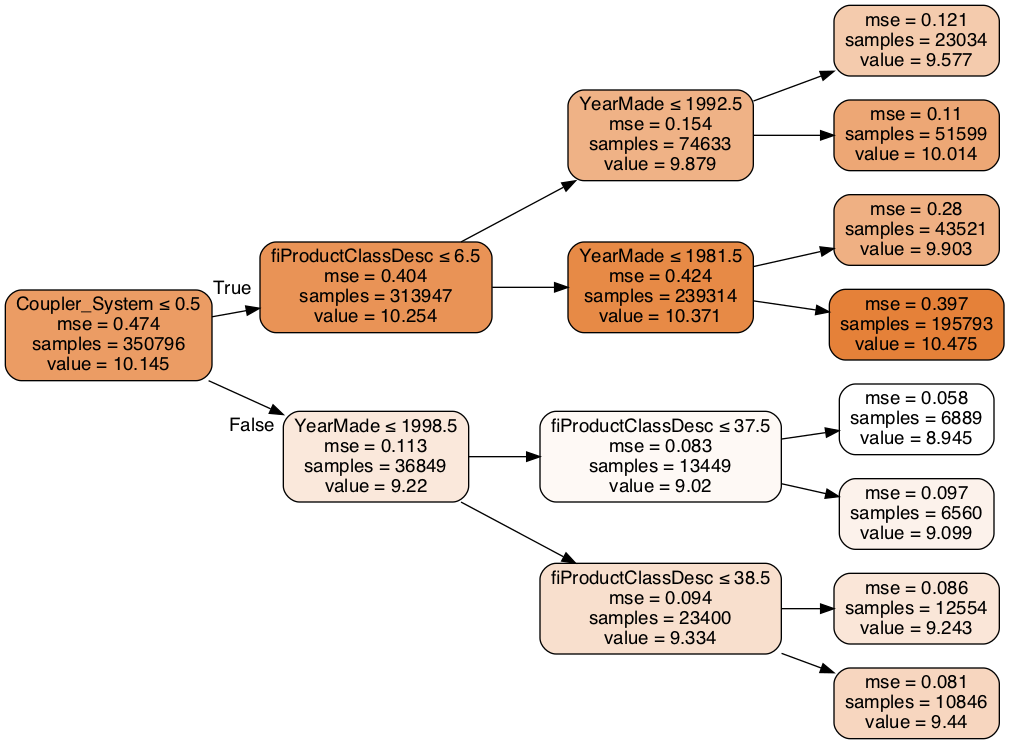

In [43]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, feature_names=data_X.columns,
                filled=True, rounded=True, rotate=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Podemos controlar la arquitectura del Random Forest usando los siguientes atributos:

- `min_sample_leaf`: Parar la división de nodos cuando el número de muestras es igual o menor a este parámetro.
- `max_features`: también podemos tomar un subconjunto de los atributos.
- `n_estimators`: podemos controlar el número de arboles a utilizar

In [44]:
modelo = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5)
%time modelo.fit(X_entrenamiento, y_entrenamiento)

CPU times: user 3min 13s, sys: 1.74 s, total: 3min 15s
Wall time: 28.3 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

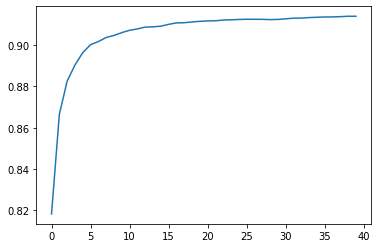

In [45]:
from sklearn import metrics

predicciones = np.stack([arbol.predict(X_validacion) for arbol in modelo.estimators_])
plt.plot([metrics.r2_score(y_validacion, np.mean(predicciones[:i+1], axis=0)) for i in range(40)]);

In [46]:
imprimir_exactitud(modelo)

RMSE Entrenamiento:  11.398365230037703
RMSE Validación:  22.134677058532397
 R2  Entrenamiento:  97.25826008179018
 R2  Validación:  91.39472477989659


## Ingeniería de Atributos

Los atributos que van al modelo son tan importantes como el mismo modelo.

Es importante entender las siguientes cosas sobre los atributos.

- Cuál es la importancia de cada atributo?
- Qué tan similar son entre ellos?
- Cómo interactuan los atributos entre ellos?
- Cómo hacer los atributos realmente independientes del tiempo?

### Importancia de los atributos

La única forma de encontrar la importancia de un atributo se puede describir con la siguiente cita:

> No sabes lo que tienes hasta que lo pierdes - Chester Bennington

Si brarajamos aletoriamente los valores de un atributo pero mantenemos todo lo demas igual, como empeora el rendimiento del modelo. Entre peor se comporta el modelo, mas importante es el atributo.

In [47]:
def importancia_atributo(self, modelo, X_validacion):
    
    def barajar_columna(nombre_columna, X_validacion):
        df_temporal = X_validacion.copy()
        df_temporal[nombre_columna] = np.random.permutation(
            df_temporal[nombre_columna].values)
        return df_temporal
    
    prediccion_actual = modelo.predict(X_validacion)
    
    return [(1 - r2_score(prediccion_actual, modelo.predict(
        barajar_columna(columna, X_validacion)))) for columna in X_validacion.columns]

Esta función describe la importancia del atributo

In [19]:
modelo = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              max_features=0.5, n_jobs=-1, oob_score=True)
modelo.fit(X_entrenamiento, y_entrenamiento)

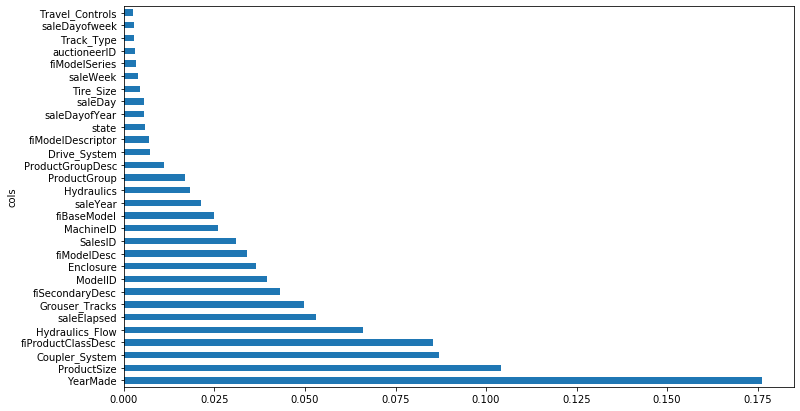

In [48]:
importancia_atributo = pd.DataFrame({'cols':data_X.columns, 'imp':modelo.feature_importances_}
                                   ).sort_values('imp', ascending=False)
importancia_atributo[:30].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

Podemos remover los que tienen una importancia menor a 0.005. Nos quedan 23 atributos. Grafiquemos la importancia de nuevo y puntemos el modelo.

In [49]:
a_mantener = importancia_atributo[importancia_atributo.imp > 0.005].cols

data_X_mantener = data_X[a_mantener].copy()
X_entrenamiento, X_validacion = dividir_datos(data_X_mantener, n_entrenamiento)

modelo = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              max_features=0.5, n_jobs=-1, oob_score=True)
modelo.fit(X_entrenamiento, y_entrenamiento)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

RMSE Entrenamiento:  11.92856513874992
RMSE Validación:  22.04420775310335
 R2  Entrenamiento:  96.99726137260437
 R2  Validación:  91.46492433983934
   OOB    :  91.73759495697468


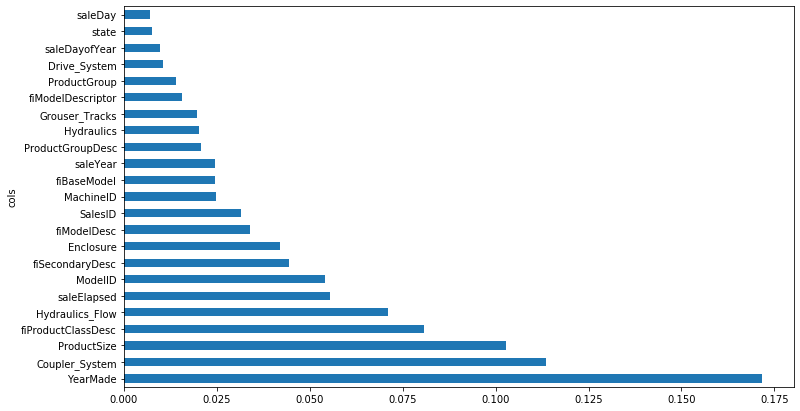

In [50]:
imprimir_exactitud(modelo)
importancia_atributo = pd.DataFrame({'cols':data_X_mantener.columns, 'imp':modelo.feature_importances_}
                                   ).sort_values('imp', ascending=False)
importancia_atributo[:30].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

`YearMade`, `Coupler_System` y `ProductSize` son los 3 atributos más importantes y tenemos un puntaje de validación de 89.2%

### Correlación entre Atributos

La combinación de atributos similares se puede hacer pasando por todos los pares y agrupando los que estan mas cercanos entre si. Este tipo de agrupamineto jerarquico trabaja en base a la ordinalidad de los atributos. Que es similar a como trabaja random Forest. Cuando divide un nodo, solo le importa el orden de los datos ordenados y no sus valores. Un coeficiente comun para medir este tipo de correlación es el coeficiente de spearman.

<function matplotlib.pyplot.show(*args, **kw)>

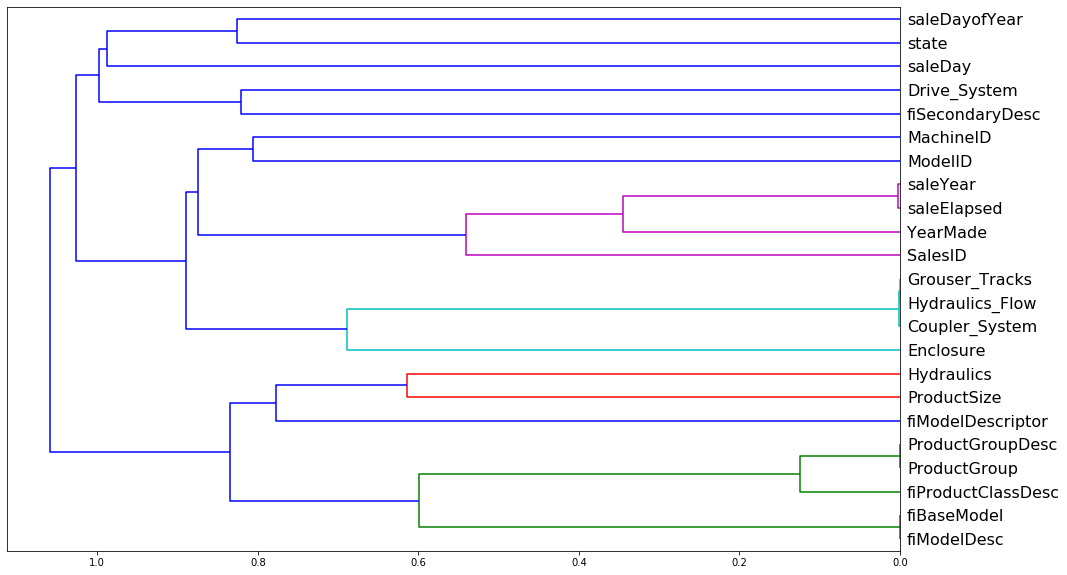

In [51]:
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr

correlacion = np.round(spearmanr(data_X_mantener).correlation, 4)

plt.figure(figsize=(16,10))
hc.dendrogram(hc.linkage(hc.distance.squareform(1 - correlacion),
                        method='average'),
             labels=data_X_mantener.columns, orientation='left',
             leaf_font_size=16)
plt.show

Los atributos que estan correlacionados se conectan mas rapidamente. Con esto, podemos ver que `saleYear` y `saleElapsed` son son similares lo que es esperado ya que ambos son dependientes del tiempo. Tambien son similares `Hydraulics_flow` y `Grouser_Tracks`, `fiBaseModel` y `fiModelDesc`, `ProductGroup` y `ProductGroupDesc`.

Si dos atributos son similares removiendo uno de ellos no afectaran la exactitud de nuestro modelo. Eliminemoslos y medimos la exactitud

In [56]:
def obtener_oob(dataframe):
    modelo = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              max_features=0.5, n_jobs=-1, oob_score=True)
    X, _ = dividir_datos(dataframe, n_entrenamiento)
    modelo.fit(X, y_entrenamiento)
    return modelo.oob_score_ * 100

obtener_oob(data_X_mantener)

91.75879344383867

In [55]:
a_eliminar = ['saleYear', 'fiBaseModel', 'Hydraulics_Flow', 'ProductGroupDesc']
obtener_oob(data_X_mantener.drop(a_eliminar, axis=1))

91.58977428785182

El puntaje global OOB bajo un poco pero no significativamente. Corramos el modelo de nuevo con la data y observemos el tiempo.

Como no hacen mucho daño podemos remover `saleYear`, `Hydraulics_Flow` y `fiBaseModel`.

In [57]:
data_X_mantener.drop(a_eliminar, axis=1, inplace=True)
X_entrenamiento, X_validacion = dividir_datos(data_X_mantener, n_entrenamiento)

modelo = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              max_features=0.5, n_jobs=-1, oob_score=True)
%time modelo.fit(X_entrenamiento, y_entrenamiento)
imprimir_exactitud(modelo)

CPU times: user 1min 30s, sys: 1.25 s, total: 1min 31s
Wall time: 15.5 s
RMSE Entrenamiento:  12.035272541295274
RMSE Validación:  22.044825096960135
 R2  Entrenamiento:  96.94329887584549
 R2  Validación:  91.46444628679575
   OOB    :  91.64534491980552
